In [1]:
#Autoencoder - Reconstruct the input 

#Fraud

#Normal Train Autoencoder with Normal transactions

#Test of autoencoder I will pass 

#Fraud and normal data

#Autoencoder calculates the reconstruction error



In [29]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from matplotlib.pylab import histogram
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
#Import the dataset
df=pd.read_csv('/content/creditcard.csv')

In [4]:
df.shape

(284807, 31)

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
#0 is normal, 1 is a fraud transaction

In [9]:
#Check for missing values
df.isnull().values.any()

False

In [10]:
count_classes=pd.value_counts(df['Class'])

In [11]:
#We have way more normal than fraud cases
#This is highly imbalanced data
count_classes

0    284315
1       492
Name: Class, dtype: int64

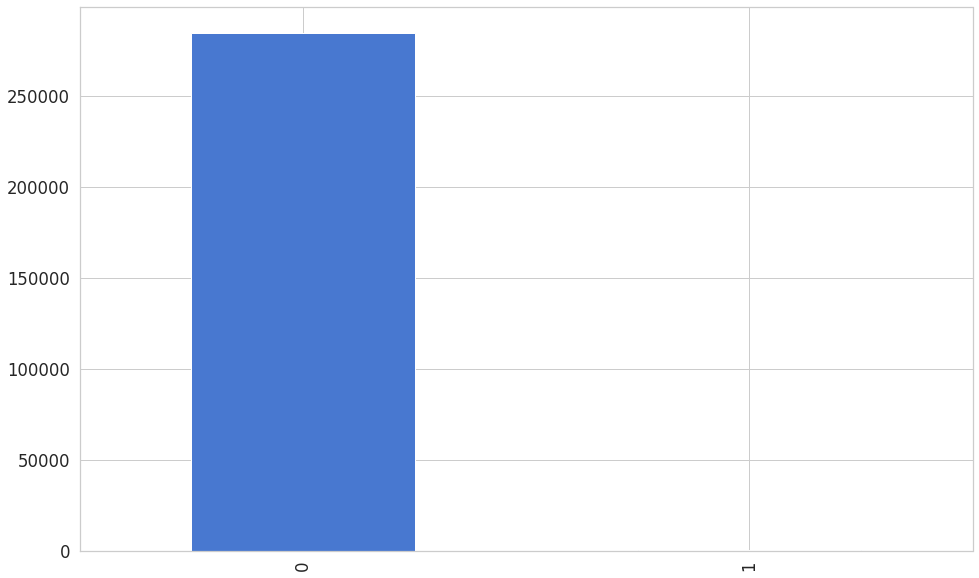

In [12]:
#There are so many normal cases, we can't even visualize fraud
count_classes.plot(kind='bar')

In [13]:
frauds=df[df['Class']==1]
normal=df[df['Class']==0]

In [14]:
frauds.shape

(492, 31)

In [15]:
normal.shape

(284315, 31)

In [17]:
#Stats
normal['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [19]:
frauds['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

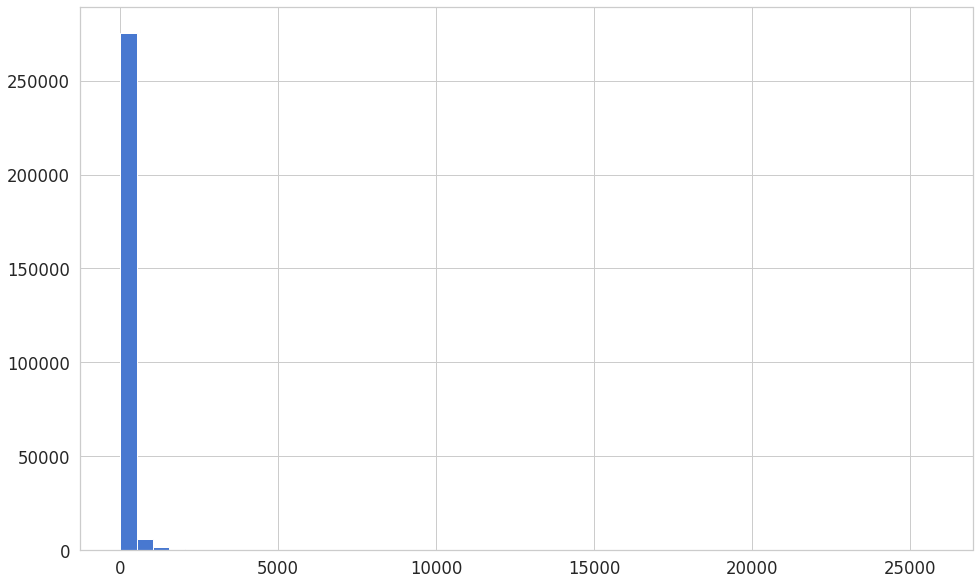

In [23]:
normal['Amount'].hist(bins=50)

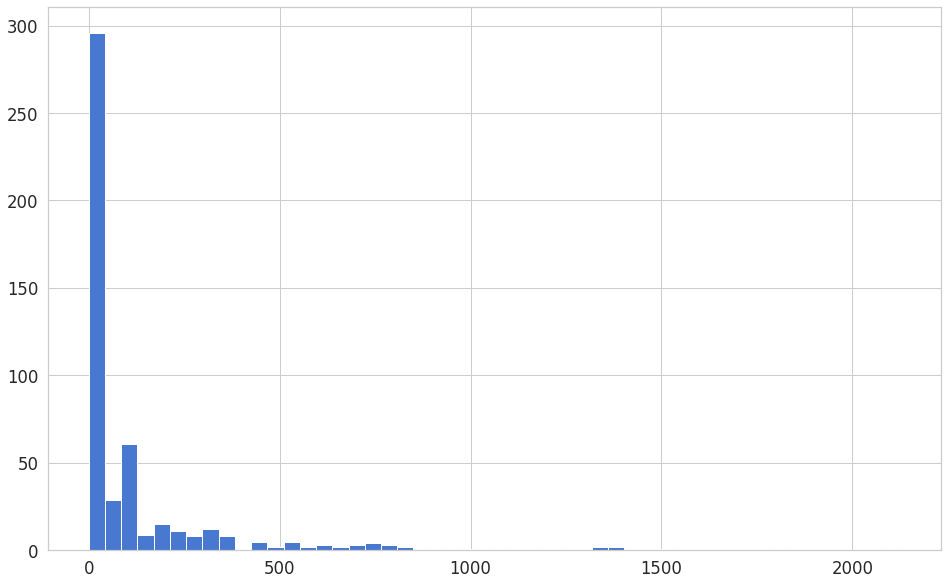

In [24]:
frauds['Amount'].hist(bins=50)

In [26]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [28]:
df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [30]:
#Normalization
data=df.drop(['Time'],axis=1)
sc=StandardScaler()
data['Amount']=sc.fit_transform(data['Amount'].values.reshape(-1,1))

In [31]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [34]:
#Prepare training data and testing data
X_train,X_test=train_test_split(data,test_size=0.2,random_state=42)
X_train=X_train[X_train['Class']==0]

#Drop class label from training data
X_train=X_train.drop(['Class'],axis=1)

#Autoencoder doesn't need the output label
#...no need to pass label along input label, just like PCA


In [35]:
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
223361,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,-0.030441,...,-0.125390,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,-0.313289
165061,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,0.611115,...,-0.470372,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,-0.169717
238186,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,-0.638222,...,0.012227,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,-0.305292
150562,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,0.560595,...,-0.253757,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,0.116306
138452,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,1.221746,...,-0.012320,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,-0.250239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,1.173488,0.100792,0.490512,0.461596,-0.296377,-0.213165,-0.165254,0.119221,-0.114199,0.079128,...,-0.157534,-0.186027,-0.574283,0.161405,-0.006140,0.091444,0.109235,-0.020922,0.003967,-0.345313
259178,-0.775981,0.144023,-1.142399,-1.241113,1.940358,3.912076,-0.466107,1.360620,0.400697,-0.654029,...,-0.295730,0.037078,-0.019575,0.241830,0.682820,-1.635109,-0.770941,0.066006,0.137056,0.003520
131932,-0.146609,0.992946,1.524591,0.485774,0.349308,-0.815198,1.076640,-0.395316,-0.491303,-0.212753,...,0.007155,0.052649,0.354089,-0.291198,0.402849,0.237383,-0.398467,-0.121139,-0.196195,-0.337477
146867,-2.948638,2.354849,-2.521201,-3.798905,1.866302,2.727695,-0.471769,2.217537,0.580199,-0.027572,...,0.417396,-0.332759,-1.047514,0.143326,0.678869,0.319710,0.426309,0.496912,0.335822,-0.349231


In [37]:
y_test=X_test['Class']
X_test=X_test.drop(['Class'],axis=1)

In [38]:
X_train.values

array([[ 1.95504092e+00, -3.80782711e-01, -3.15012853e-01, ...,
         4.51682478e-02, -4.71447917e-02, -3.13288512e-01],
       [-4.00975239e-01, -6.26942769e-01,  1.55533881e+00, ...,
        -3.70468822e-01, -1.44791686e-01, -1.69717237e-01],
       [ 7.25090164e-02,  8.20565650e-01, -5.61350916e-01, ...,
         2.06394866e-01,  7.02877702e-02, -3.05292340e-01],
       ...,
       [-1.46608925e-01,  9.92946123e-01,  1.52459137e+00, ...,
        -1.21139194e-01, -1.96195328e-01, -3.37476933e-01],
       [-2.94863809e+00,  2.35484929e+00, -2.52120111e+00, ...,
         4.96912107e-01,  3.35821632e-01, -3.49231307e-01],
       [ 1.23317435e+00, -7.84850501e-01,  3.86783869e-01, ...,
         1.21657270e-03,  3.85878912e-02,  9.85543469e-02]])

In [39]:
X_test.shape

(56962, 29)

In [40]:
X_train.shape

(227451, 29)

In [41]:
#Create the architecture
#Design four fully connected layers (FCN), 2 encoder(14,7)  2 Decoder(7,29)
#Input is 29

#Input
input_dim=X_train.shape[1]
input_layer=Input(shape=(input_dim,))


In [43]:
#Encoder layer
encoder=Dense(14,activation='tanh',activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder=Dense(7,activation='relu')(encoder)


In [49]:
#Decoder layer
decoder=Dense(7,activation='tanh')(encoder)
decoder=Dense(input_dim,activation='relu')(decoder)

autoencoder=Model(inputs=input_layer,outputs=decoder)

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_1 (Dense)             (None, 14)                420       
                                                                 
 dense_2 (Dense)             (None, 7)                 105       
                                                                 
 dense_9 (Dense)             (None, 7)                 56        
                                                                 
 dense_10 (Dense)            (None, 29)                232       
                                                                 
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________


In [51]:
#Compile the model
autoencoder.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [53]:
#Epochs
epochs=50
batch_size=32

history=autoencoder.fit(X_train,X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test,X_test), verbose=1)

Epoch 1/50
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7215 - accuracy: 0.6999 - val_loss: 0.7493 - val_accuracy: 0.6976
Epoch 2/50
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7149 - accuracy: 0.7076 - val_loss: 0.7478 - val_accuracy: 0.7015
Epoch 3/50
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7102 - accuracy: 0.7130 - val_loss: 0.7413 - val_accuracy: 0.7121
Epoch 4/50
7108/7108 [==============================] - 22s 3ms/step - loss: 0.7064 - accuracy: 0.7186 - val_loss: 0.7378 - val_accuracy: 0.7220
Epoch 5/50
7108/7108 [==============================] - 30s 4ms/step - loss: 0.7038 - accuracy: 0.7229 - val_loss: 0.7365 - val_accuracy: 0.7208
Epoch 6/50
7108/7108 [==============================] - 24s 3ms/step - loss: 0.7022 - accuracy: 0.7220 - val_loss: 0.7341 - val_accuracy: 0.7151
Epoch 7/50
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7006 - accuracy: 0.7219 - val_loss: 0.7329 - val_ac

In [54]:
autoencoder.save('AEModel.h5')

In [55]:
model=load_model('AEModel.h5')


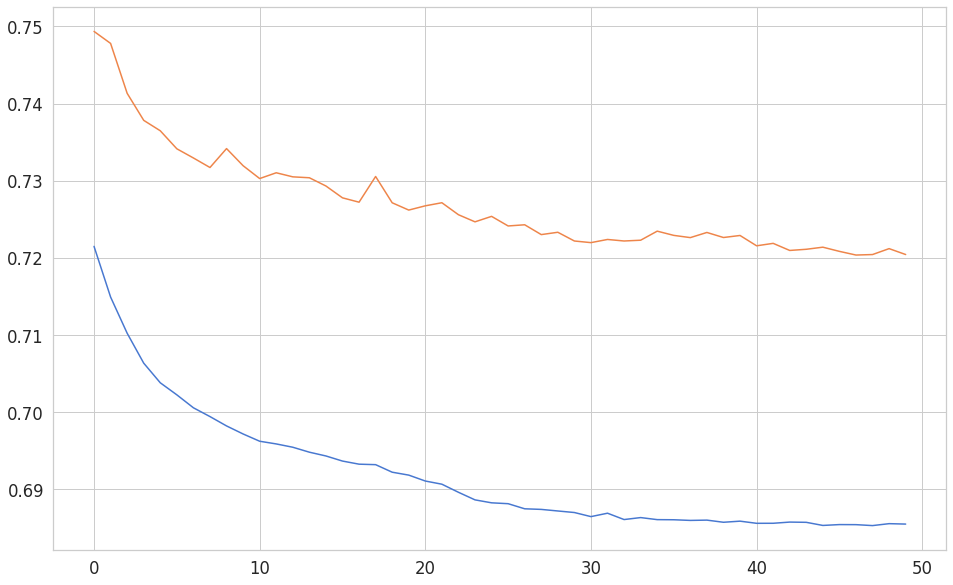

In [57]:
#plot the losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [60]:
pred=model.predict(X_test)

1781/1781 [==============================] - 3s 2ms/step


In [61]:
#Create a dataframe
mse=np.mean(np.power(X_test-pred,2),axis=1)


In [62]:
mse

43428     80.491908
49906      0.835076
29474      0.197065
276481     0.342618
278846     0.184834
            ...    
75723      0.677602
252263     0.193906
221246     0.501743
81910      0.121345
59490      1.634718
Length: 56962, dtype: float64

In [63]:
#The first transaction here is fraud - 80.49

In [64]:
#Create a dataframe
error_df=pd.DataFrame({'Recons_Error':mse,'Actual_class':y_test})

In [65]:
error_df

,Recons_Error,Actual_class
43428,80.491908,1
49906,0.835076,0
29474,0.197065,0
276481,0.342618,0
278846,0.184834,0
...,...,...
75723,0.677602,0
252263,0.193906,0
221246,0.501743,0
81910,0.121345,0


In [66]:
#Actual label is 1 for fraud, 0 is normal

In [67]:
error_df.tail(50)

,Recons_Error,Actual_class
82210,0.490043,0
123224,0.419982,0
142598,0.489237,0
248050,4.866882,0
280878,0.167683,0
106070,0.213367,0
15996,0.168780,0
129641,0.178356,0
241122,0.563855,0
269946,0.421180,0


In [70]:
error_df['Actual_class'].value_counts()

0    56864
1       98
Name: Actual_class, dtype: int64

In [71]:
#We have 98 fraud cases

In [72]:
error_df[error_df['Actual_class']==1]

,Recons_Error,Actual_class
43428,80.491908,1
116404,5.942707,1
215984,10.435753,1
249239,1.377757,1
146790,1.012019,1
...,...,...
152223,95.302255,1
6903,19.004138,1
276864,4.840590,1
199896,7.164160,1


In [74]:
model.evaluate(X_test,X_test)

1781/1781 [==============================] - 5s 3ms/step - loss: 0.7204 - accuracy: 0.7442


[0.7204302549362183, 0.7441627979278564]

In [75]:
#Loss 72, 74 accuracy